In [1]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = matrix1.max() - matrix1.min()
        return ssim(matrix1, matrix2, data_range=data_range)
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]
    return df, best_shift['Up'], best_shift['Right']
    
from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y
    
def calculate_okubo_weis(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std



## No Tilt

In [118]:
def calculate_eddy(WIDTH=500000, DEPTH_LAYERS=10, eta0=1, L=1e5, H=1200, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=-0.01):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, and temperature field for an ocean eddy.
    
    Parameters:
    - WIDTH: Horizontal extent of the grid (eddy scale) in meters.
    - DEPTH_LAYERS: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a: Linear coefficient for stratification.
    - b: Exponential coefficient for density anomaly.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -40 degrees.
    - alpha_1: Coefficient for x_c(z), affects the horizontal shift of the eddy center with depth in the x direction.
    - alpha_2: Coefficient for y_c(z), affects the horizontal shift of the eddy center with depth in the y direction.
    - T0: Surface temperature at z = 0 (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    
    Returns:
    - U: 3D matrix for the U (x-component) velocity field.
    - V: 3D matrix for the V (y-component) velocity field.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - CS: Speed magnitude.
    """
    
    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-40))  # Coriolis parameter for latitude -40 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-WIDTH//2, WIDTH//2, 100)  # x-coordinates
    y = np.linspace(-WIDTH//2, WIDTH//2, 100)  # y-coordinates
    z = np.linspace(-H, 0, DEPTH_LAYERS)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    def g_z(z, H):
        return np.exp(z / H)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.sqrt((x_3d - x_c)**2 + (y_3d - y_c)**2)

    # Calculate density anomaly sigma with the modified equation
    sigma = rho0 - a * z_3d + b * f_r_rc(r_c, L) * g_z(z_3d, H)

    # Calculate 3D geostrophic velocity components for the eddy
    U = 2 * g * y_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r_c**2 / L**2)
    V = -2 * g * x_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r_c**2 / L**2)

    # Calculate speed magnitude
    CS = np.sqrt(U**2 + V**2)
    
    # Calculate temperature as a linear function of depth with horizontal variation
    # T0 is the surface temperature, dTdz is the rate of temperature decrease with depth
    T = T0 + dTdz * z_3d - 0.5 * f_r_rc(r_c, L)  # Horizontal variation based on distance from the eddy center
    TA = T - np.mean(T)

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    TA = np.flip(TA, axis=2)
    CS  = np.flip(CS, axis=2)
    z = np.flip(z)
    
    return U, V, sigma, TA, CS, x/1000, y/1000, z


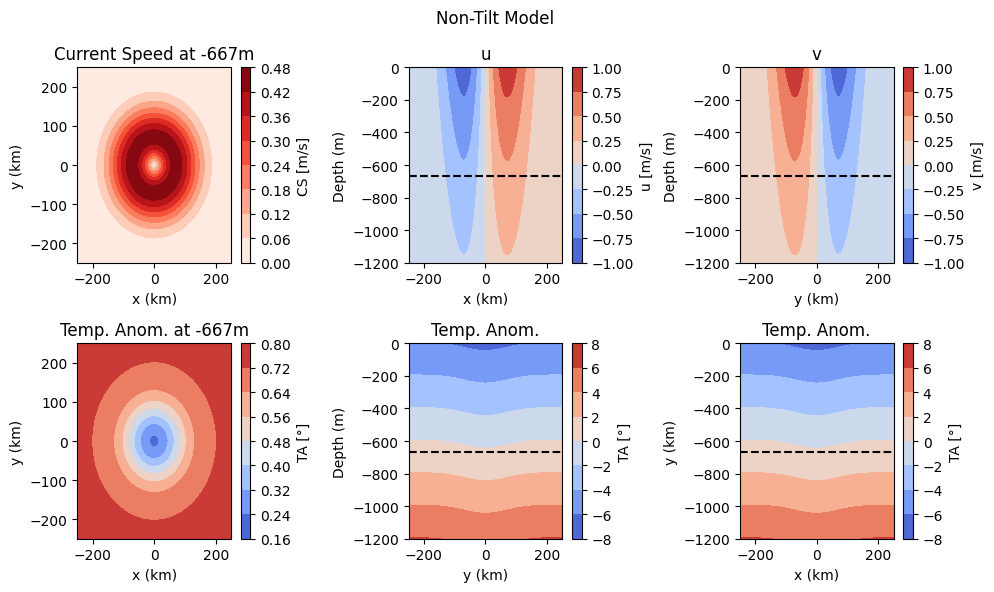

In [124]:
U, V, sigma, TA, CS, x, y, z = calculate_eddy()

DEPTH_LVL = 5
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot Current Speed
c1 = axs[0,0].contourf(x, y, CS[:,:,DEPTH_LVL].T, cmap='Reds')
fig.colorbar(c1, ax=axs[0,0], label='CS [m/s]')
axs[0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('y (km)')

# Plot u velocity
contour_u = axs[0,1].contourf(x, z, U[U.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[0,1], label='u [m/s]')
axs[0,1].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[0,1].set_title('u')
axs[0,1].set_xlabel('x (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot v velocity
contour_v = axs[0,2].contourf(y, z, V[:,V.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[0,2], label='v [m/s]')
axs[0,2].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[0,2].set_title('v')
axs[0,2].set_xlabel('y (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot Temperature Anomaly (TA) for the current depth level
c2 = axs[1,0].contourf(x, y, TA[:,:,DEPTH_LVL].T, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1,0], label='TA [°]')
axs[1,0].set_title('Temp. Anom. at '+str(round(z[DEPTH_LVL]))+'m')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('y (km)')

# Plot Temperature Anomaly at x = middle slice
temp_x = axs[1,1].contourf(x, z, TA[TA.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(temp_x, ax=axs[1,1], label='TA [°]')
axs[1,1].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[1,1].set_title('Temp. Anom.')
axs[1,1].set_xlabel('y (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature Anomaly at y = middle slice
temp_y = axs[1,2].contourf(y, z, TA[:,TA.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(temp_y, ax=axs[1,2], label='TA [°]')
axs[1,2].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
axs[1,2].set_title('Temp. Anom.')
axs[1,2].set_xlabel('x (km)')
axs[1,2].set_ylabel('y (km)')

fig.suptitle('Non-Tilt Model')

plt.tight_layout()
plt.show()


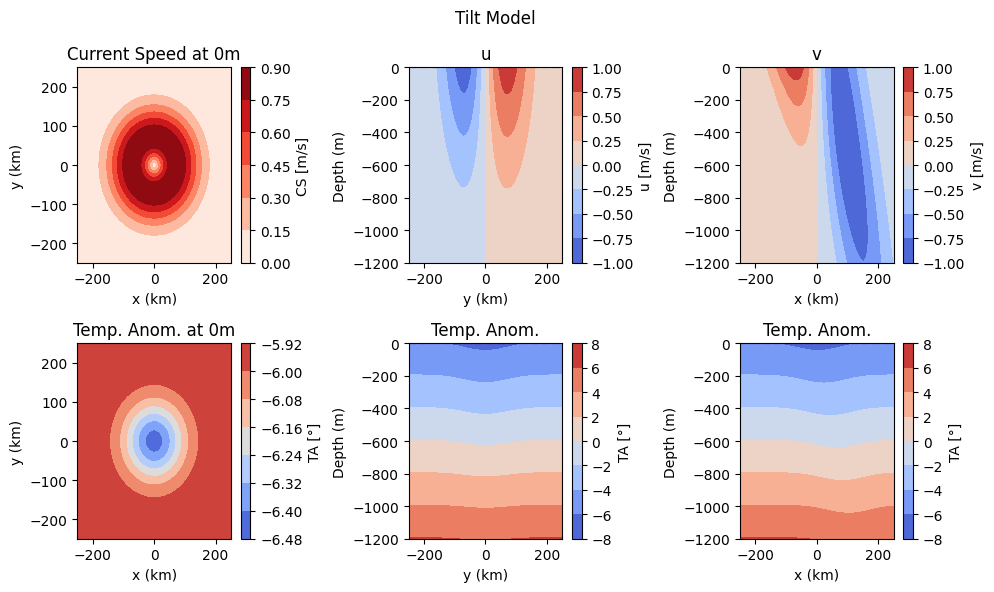

In [129]:
U_tilt, V_tilt, sigma_tilt, TA_tilt, CS_tilt, x_tilt, y_tilt, z_tilt = calculate_eddy(alpha_1=-100)

DEPTH_LVL = 0
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot Current Speed
c1 = axs[0,0].contourf(x_tilt, y_tilt, CS_tilt[:,:,DEPTH_LVL].T, cmap='Reds')
fig.colorbar(c1, ax=axs[0,0], label='CS [m/s]')
axs[0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('y (km)')

# Plot u velocity
contour_u = axs[0,1].contourf(x_tilt, z_tilt, U_tilt[U_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[0,1], label='u [m/s]')
axs[0,1].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,1].set_title('u')
axs[0,1].set_xlabel('y (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot v velocity
contour_v = axs[0,2].contourf(y_tilt, z_tilt, V_tilt[:,V_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[0,2], label='v [m/s]')
axs[0,2].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[0,2].set_title('v')
axs[0,2].set_xlabel('x (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot Temperature Anomaly (TA) for the current depth level
c2 = axs[1,0].contourf(x_tilt, y_tilt, TA_tilt[:,:,DEPTH_LVL].T, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1,0], label='TA [°]')
axs[1,0].set_title('Temp. Anom. at '+str(round(z_tilt[DEPTH_LVL]))+'m')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('y (km)')

# Plot Temperature Anomaly at x = middle slice
temp_x = axs[1,1].contourf(x_tilt, z_tilt, TA_tilt[TA_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(temp_x, ax=axs[1,1], label='TA [°]')
axs[1,1].plot([x_tilt[0],x_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,1].set_title('Temp. Anom.')
axs[1,1].set_xlabel('y (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature Anomaly at y = middle slice
temp_y = axs[1,2].contourf(y_tilt, z_tilt, TA_tilt[:,TA_tilt.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(temp_y, ax=axs[1,2], label='TA [°]')
axs[1,2].plot([y_tilt[0],y_tilt[-1]],[z_tilt[DEPTH_LVL],z_tilt[DEPTH_LVL]],'--',color='k')
axs[1,2].set_title('Temp. Anom.')
axs[1,2].set_xlabel('x (km)')
axs[1,2].set_ylabel('Depth (m)')

fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()


## OW Isosurface

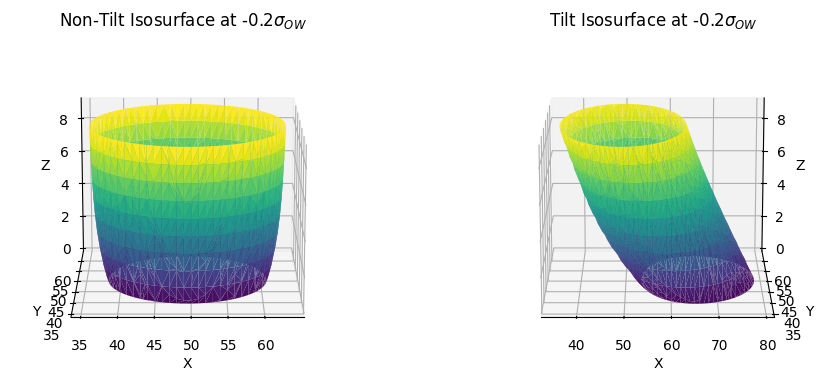

In [134]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

ow = calculate_okubo_weis(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)

ow_tilt = calculate_okubo_weis(U_tilt, V_tilt, x_tilt[1]-x_tilt[0], y_tilt[1]-y_tilt[0])
ow_tilt = normalize_matrix(ow_tilt)

fig = plt.figure(figsize=(10, 4))

# Non-Tilt Isosurface
ax1 = fig.add_subplot(121, projection='3d')
# X, Y, Z = np.meshgrid(x, y, z)
verts, faces, _, _ = measure.marching_cubes(np.flip(ow, axis=2), -0.2)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(r'Non-Tilt Isosurface at -0.2$\sigma_{OW}$')
ax1.view_init(elev=15, azim=270)

# Tilt Isosurface
ax2 = fig.add_subplot(122, projection='3d')
verts_tilt, faces_tilt, _, _ = measure.marching_cubes(np.flip(ow_tilt, axis=2), -0.2)
ax2.plot_trisurf(verts_tilt[:, 0], verts_tilt[:, 1], verts_tilt[:, 2], triangles=faces_tilt, cmap='viridis', lw=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(r'Tilt Isosurface at -0.2$\sigma_{OW}$')
ax2.view_init(elev=15, azim=270)

plt.tight_layout()
plt.show()

## SSIM 

In [138]:
def make_ssim_matrix(df):
    xs, ys, values = df.Right, df.Up, df.Correlation
    ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
    for i in np.unique(xs):
        for j in np.unique(ys):
            ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]
    return ssim_mat

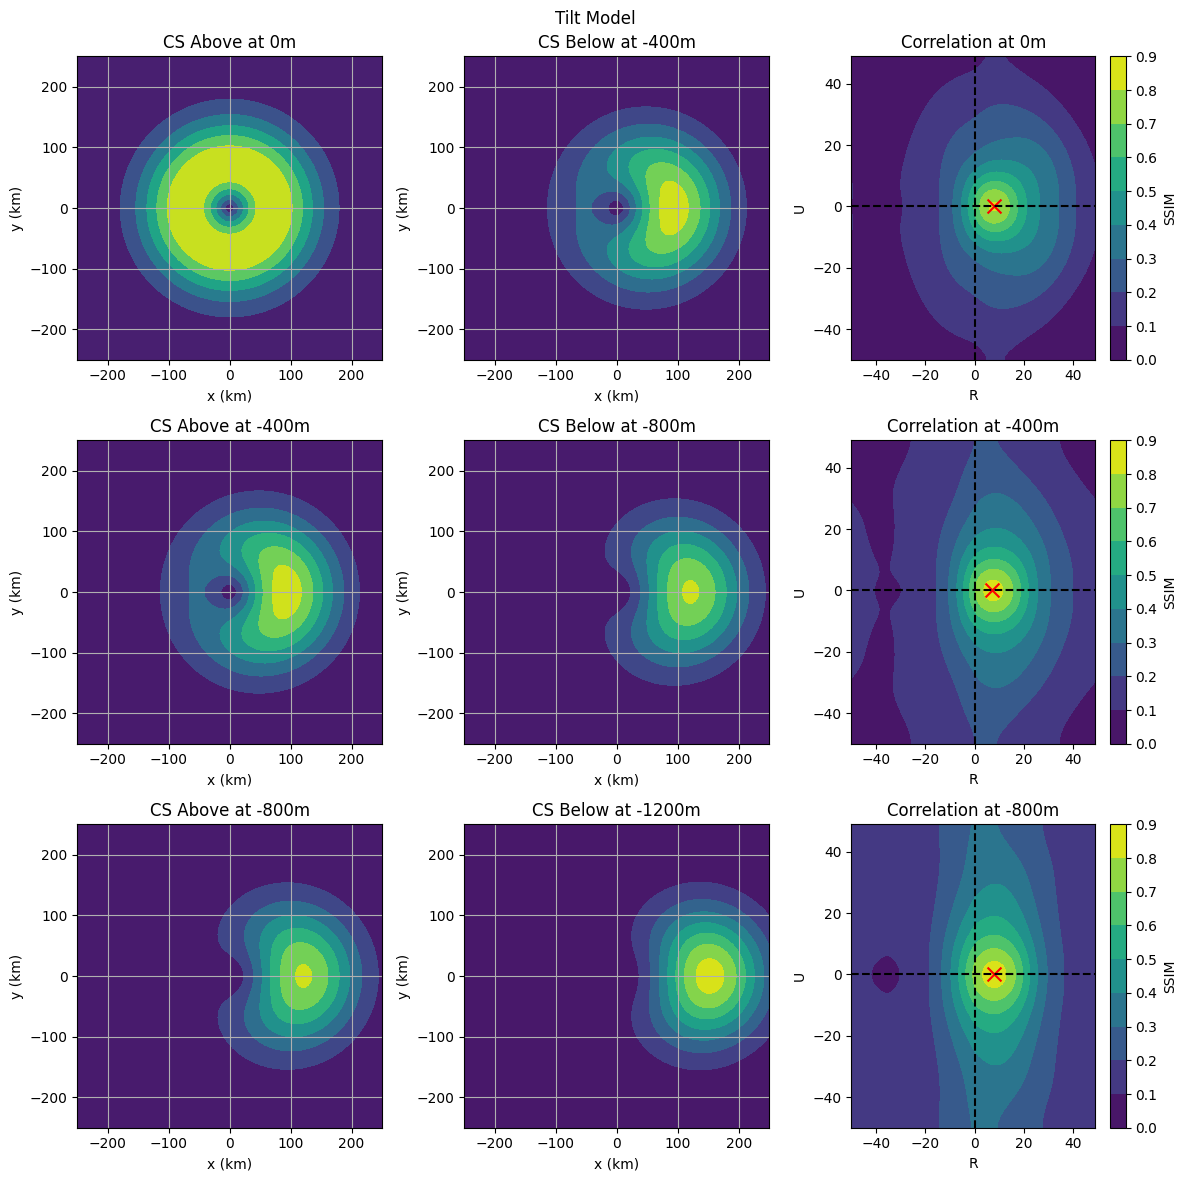

In [131]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 12))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = CS_tilt[:, :, depth_lvl].T
        Data_blw = CS_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        ax[img_row,0].contourf(x_tilt, y_tilt, Data_abv)
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        
        # Second subplot
        ax[img_row,1].contourf(x_tilt, y_tilt, Data_blw)
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        
        # Third subplot
        contour3 = ax[img_row,2].contourf(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T)
        ax[img_row,2].set_title('Correlation at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='k', linestyle='--')  
        ax[img_row,2].axhline(y=0, color='k', linestyle='--') 
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        
        cbar = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar.set_label('SSIM')
    
        img_row += 1
    
fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

The above image needs to move to the right, to match the below image

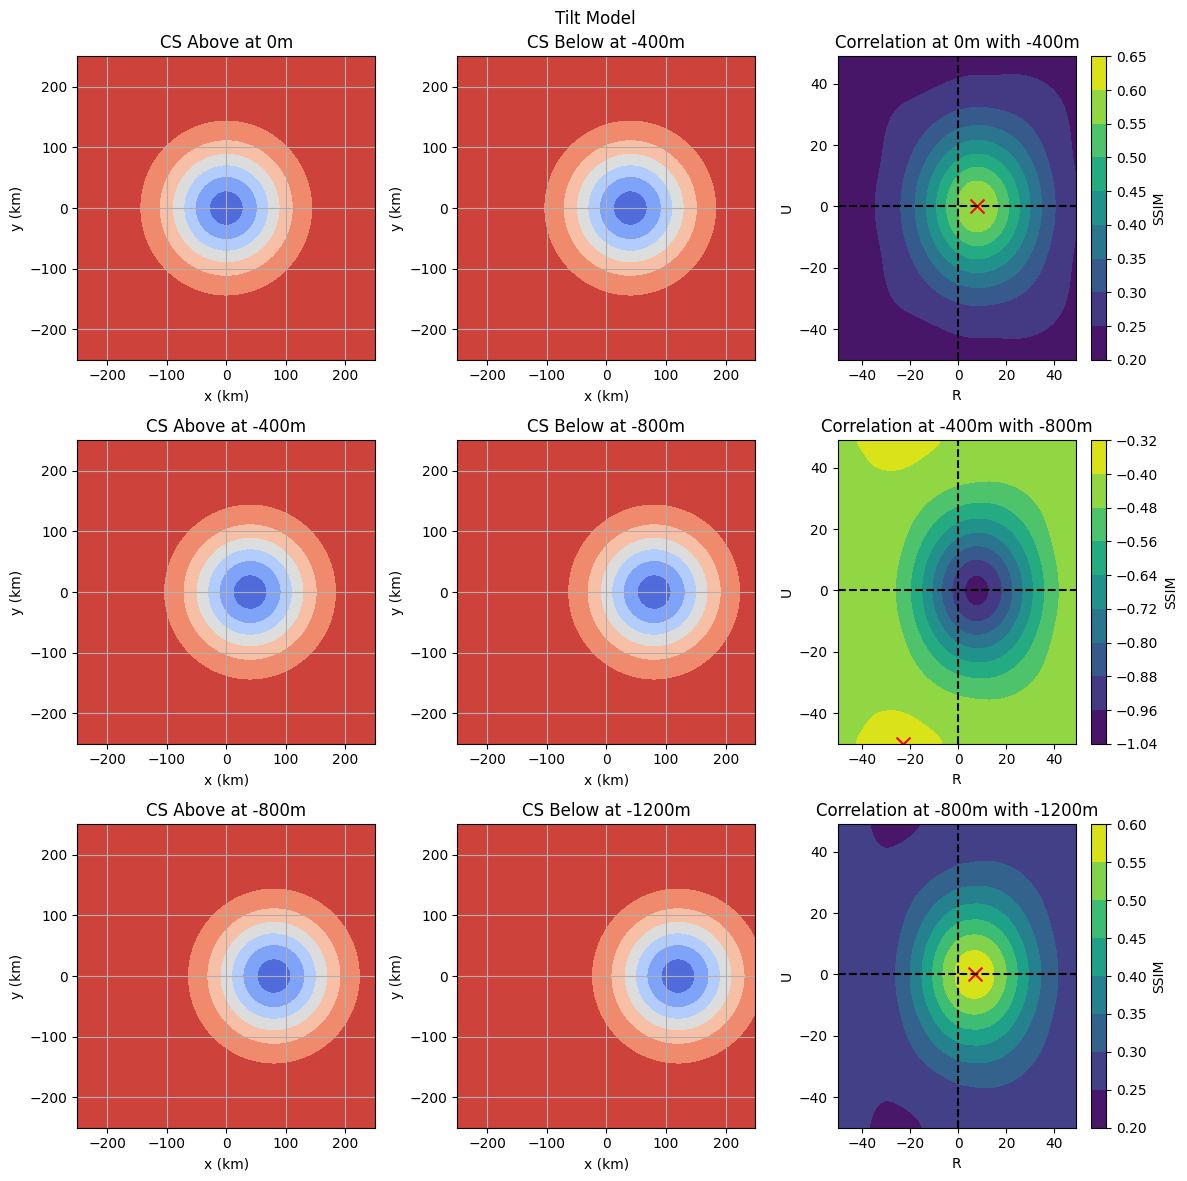

In [140]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 12))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = TA_tilt[:, :, depth_lvl].T
        Data_blw = TA_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        ax[img_row,0].contourf(x_tilt, y_tilt, Data_abv, cmap='coolwarm')
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        
        # Second subplot
        ax[img_row,1].contourf(x_tilt, y_tilt, Data_blw, cmap='coolwarm')
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        
        # Third subplot
        contour3 = ax[img_row,2].contourf(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T)
        ax[img_row,2].set_title('Correlation at '+str(round(z[depth_lvl]))+'m with '+str(round(z[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='k', linestyle='--')  
        ax[img_row,2].axhline(y=0, color='k', linestyle='--') 
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        
        cbar = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar.set_label('SSIM')
    
        img_row += 1
    
fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

## 3D SSIM Isosurface
Problem!:

Looks the same for non-tilt and tilt

SSIM is calcualted between neighbouring layers, differences are hence relatively small and do not show as tilt

In [152]:
ssim_cube = np.zeros_like(TA)
for depth_lvl in range(TA.shape[2]-1):
    Data_abv = TA[:, :, depth_lvl].T
    Data_blw = TA[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube[:,:,depth_lvl] = make_ssim_matrix(df)

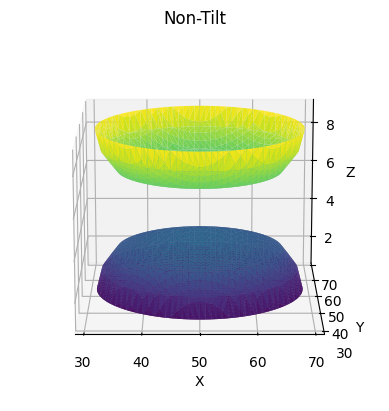

In [154]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()


In [155]:
ssim_cube_tilt = np.zeros_like(TA_tilt)
for depth_lvl in range(TA_tilt.shape[2]-1):
    Data_abv = TA_tilt[:, :, depth_lvl].T
    Data_blw = TA_tilt[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_tilt[:,:,depth_lvl] = make_ssim_matrix(df)

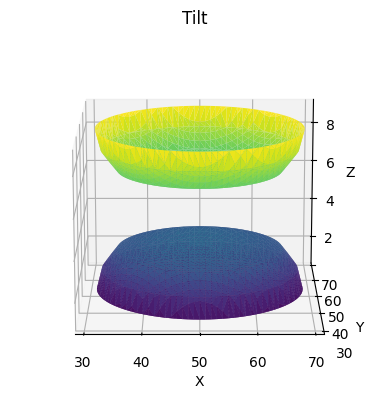

In [158]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()



In [159]:
ssim_cube_CS = np.zeros_like(CS)
for depth_lvl in range(CS.shape[2]-1):
    Data_abv = CS[:, :, depth_lvl].T
    Data_blw = CS[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_CS[:,:,depth_lvl] = make_ssim_matrix(df)

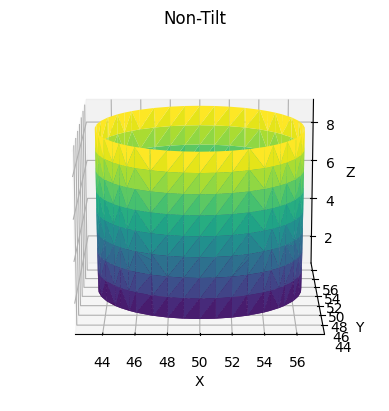

In [160]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube_CS, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()

In [161]:
ssim_cube_tilt_CS = np.zeros_like(CS_tilt)
for depth_lvl in range(CS_tilt.shape[2]-1):
    Data_abv = CS_tilt[:, :, depth_lvl].T
    Data_blw = CS_tilt[:, :, depth_lvl + 1].T
    df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    ssim_cube_tilt_CS[:,:,depth_lvl] = make_ssim_matrix(df)

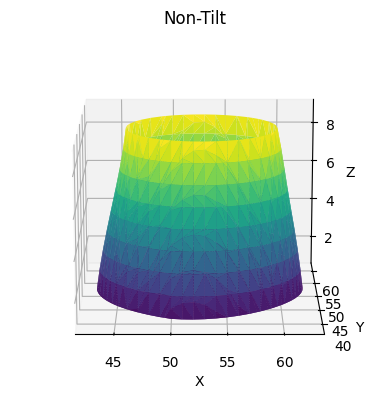

In [162]:
from skimage import measure

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Generate the isosurface
verts, faces, _, _ = measure.marching_cubes(np.flip(ssim_cube_tilt_CS, axis=2), .7)

# Plot the isosurface
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces,
                 cmap='viridis', lw=1)

# Set labels and title
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

plt.show()

In [168]:
im, jm = ssim_cube_tilt_CS.shape[0]//2, ssim_cube_tilt_CS.shape[1]//2

xc, yc = [], []
i0, j0 = 0, 0
for depth_lvl in range(ssim_cube_tilt_CS.shape[-1]):
    i, j = np.unravel_index(np.argmax(ssim_cube_tilt_CS[:,:,depth_lvl]), ssim_cube_tilt_CS[:,:,depth_lvl].shape)
    i -= im
    j -= jm
    i0 += i
    j0 += j

    xc.append(x[i0])
    yc.append(y[j0])
    
    

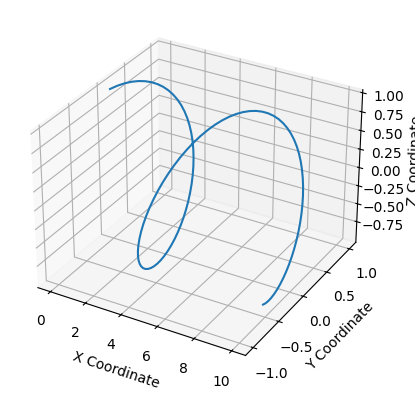

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
xc = np.linspace(0, 10, 100)  # x-coordinates
yc = np.sin(xc)                # y-coordinates (example: sine function)
z = np.cos(xc)                 # z-coordinates (example: cosine function)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.plot(xc, yc, z)

# Adding labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Show the plot
plt.show()


In [169]:
z

array([    0.        ,  -133.33333333,  -266.66666667,  -400.        ,
        -533.33333333,  -666.66666667,  -800.        ,  -933.33333333,
       -1066.66666667, -1200.        ])